## Data Load, Image Preprocessing and Data Split

In [2]:
pip install transformers torch datasets tqdm scikit-learn Pillow

Note: you may need to restart the kernel to use updated packages.


In [3]:
from transformers import AutoImageProcessor, ViTForImageClassification
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from datasets import load_dataset
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import accuracy_score

In [4]:
# Load dataset
data_dir = '/exchange/dspro01/group3/data/train'  
dataset = load_dataset('imagefolder', data_dir=data_dir)

Resolving data files:   0%|          | 0/28800 [00:00<?, ?it/s]

In [5]:
# Initialize the AutoImageProcessor for preprocessing images using the fast version
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k", use_fast=True)


In [6]:
# Function to preprocess images
def preprocess_images(example):
    # Use the image processor to convert the image to tensors
    # The processor automatically handles the transformation and resizing
    processed = image_processor(example['image'], return_tensors="pt")
    
    # Make sure the processed tensors are properly structured for the dataset
    example['pixel_values'] = processed.pixel_values.squeeze()  # Remove extra batch dimension
    return example

In [9]:
# Apply preprocessing on the dataset with parallelization
train_dataset = dataset['train']

# Apply preprocessing without parallelization
train_dataset = train_dataset.map(preprocess_images, batched=False)

Map:   0%|          | 0/28800 [00:00<?, ? examples/s]

In [10]:
# Speichern des Datasets im Ordner "vision_preprocessed_data"
train_dataset.save_to_disk("vision_preprocessed_data")

Saving the dataset (0/65 shards):   0%|          | 0/28800 [00:00<?, ? examples/s]

In [11]:
from datasets import load_from_disk

# Laden des Datasets aus dem Ordner "vision_preprocessed_data"
train_dataset = load_from_disk("vision_preprocessed_data")

Loading dataset from disk:   0%|          | 0/65 [00:00<?, ?it/s]

In [12]:
# Set the seed for reproducibility
seed = 42
torch.manual_seed(seed)

In [13]:
# Split the dataset into training and validation sets
total_size = len(train_dataset)
train_size = int(0.8 * total_size)   
val_size = int(0.2 * total_size)

In [14]:
total_size

28800

In [15]:
# Generate splits using the seed for reproducibility
generator = torch.Generator().manual_seed(seed)  
train_split, val_split = random_split(train_dataset, [train_size, val_size], generator=generator)

In [16]:
# Verify the sizes of the splits
assert len(train_split) == train_size
assert len(val_split) == val_size

In [17]:
def collate_fn(batch):
    pixel_values = torch.stack([torch.tensor(item['pixel_values']) for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    return {'pixel_values': pixel_values, 'label': labels}

In [28]:
# Create DataLoader for training and validation
batch_size = 64
train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True, num_workers=10, collate_fn=collate_fn)
val_loader = DataLoader(val_split, batch_size=batch_size, shuffle=False, num_workers=10, collate_fn=collate_fn)

## Model

In [29]:
# Load the pre-trained Vision Transformer model and set the number of labels (categories)
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", 
                                                 num_labels=len(dataset['train'].features['label'].names))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
import torch
print("CUDA verfügbar:", torch.cuda.is_available())

CUDA verfügbar: True


In [31]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [32]:
# Set device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
torch.cuda.empty_cache()

In [36]:
# Move model to the selected device
model = model.to(device)

In [37]:
# Training and evaluation loop
num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        # Move pixel values and labels to the correct device (GPU or CPU)
        inputs = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.logits, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
    
    train_loss /= len(train_loader)
    train_acc = train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            
            val_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.logits, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    
    # Print results for this epoch
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

Epoch 1/10 - Validation: 100%|██████████| 90/90 [02:00<00:00,  1.34s/it]


Train Loss: 1.6043 Acc: 0.6733
Val Loss: 1.0001 Acc: 0.8236


Epoch 2/10 - Validation: 100%|██████████| 90/90 [01:58<00:00,  1.32s/it]


Train Loss: 0.7597 Acc: 0.8684
Val Loss: 0.6244 Acc: 0.8773


Epoch 3/10 - Validation: 100%|██████████| 90/90 [02:00<00:00,  1.34s/it]


Train Loss: 0.4881 Acc: 0.9157
Val Loss: 0.4878 Acc: 0.8953


Epoch 4/10 - Validation: 100%|██████████| 90/90 [01:58<00:00,  1.32s/it]


Train Loss: 0.3408 Acc: 0.9434
Val Loss: 0.4185 Acc: 0.9003


Epoch 5/10 - Validation: 100%|██████████| 90/90 [01:59<00:00,  1.33s/it]


Train Loss: 0.2474 Acc: 0.9628
Val Loss: 0.3858 Acc: 0.9061


Epoch 6/10 - Validation: 100%|██████████| 90/90 [02:01<00:00,  1.35s/it]


Train Loss: 0.1831 Acc: 0.9737
Val Loss: 0.3773 Acc: 0.8972


Epoch 7/10 - Validation: 100%|██████████| 90/90 [02:01<00:00,  1.35s/it]


Train Loss: 0.1371 Acc: 0.9814
Val Loss: 0.3575 Acc: 0.9082


Epoch 8/10 - Validation: 100%|██████████| 90/90 [01:59<00:00,  1.33s/it]


Train Loss: 0.1176 Acc: 0.9822
Val Loss: 0.3687 Acc: 0.9033


Epoch 9/10 - Validation: 100%|██████████| 90/90 [01:59<00:00,  1.33s/it]


Train Loss: 0.0939 Acc: 0.9867
Val Loss: 0.3499 Acc: 0.9080


Epoch 10/10 - Validation: 100%|██████████| 90/90 [01:59<00:00,  1.33s/it]

Train Loss: 0.0747 Acc: 0.9901
Val Loss: 0.3539 Acc: 0.9113


## Visualization

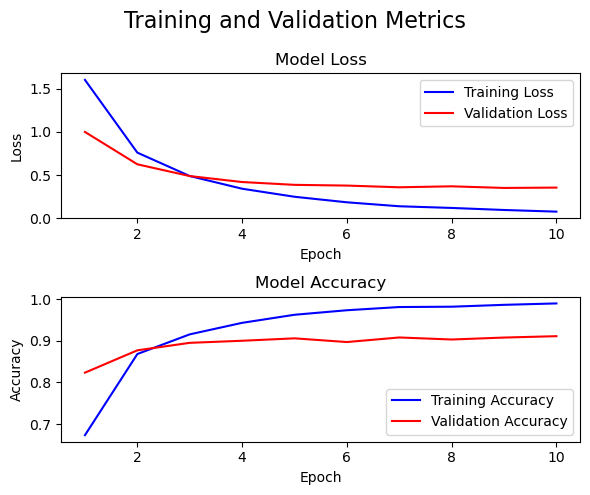

Best validation accuracy: 0.9113 (Epoch 10)
Final accuracy gap (train - val): 0.0788


In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your training output
epochs = range(1, 11)

train_loss = [1.6043, 0.7597, 0.4881, 0.3408, 0.2474, 0.1831, 0.1371, 0.1176, 0.0939, 0.0747]
train_acc = [0.6733, 0.8684, 0.9157, 0.9434, 0.9628, 0.9737, 0.9814, 0.9822, 0.9867, 0.9901]
val_loss = [1.0001, 0.6244, 0.4878, 0.4185, 0.3858, 0.3773, 0.3575, 0.3687, 0.3499, 0.3539]
val_acc = [0.8236, 0.8773, 0.8953, 0.9003, 0.9061, 0.8972, 0.9082, 0.9033, 0.9080, 0.9113]


           
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5))
fig.suptitle('Training and Validation Metrics', fontsize=16)

# Plot training & validation loss values
ax1.plot(epochs, train_loss, 'b-', label='Training Loss')
ax1.plot(epochs, val_loss, 'r-', label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training & validation accuracy values
ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy')
ax2.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Calculate and print best validation accuracy
best_val_acc = max(val_acc)
best_epoch = val_acc.index(best_val_acc) + 1
print(f"Best validation accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")

# Calculate and print final training-validation gap
final_train_acc = train_acc[-1]
final_val_acc = val_acc[-1]
acc_gap = final_train_acc - final_val_acc
print(f"Final accuracy gap (train - val): {acc_gap:.4f}")

In [43]:
# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
}, 'best_model.pth')

# Load the model for inference or fine-tuning
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']